In [30]:
#in_rds = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/annotation/gff_A2_black/mergedSamples/allSamples.integrated.rds" 
se_f = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1//data/annotation/gff_A2/mergedSamples/allSamples.integrated.rds"
outdir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1//data/annotation/gff_A2/mergedSamples/pseudotime_mon"
#labels_meta = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1//data/annotation/gff_A2/mergedSamples/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"


order_f = ""
to_de = FALSE


to_de = FALSE
use.seurat=FALSE
#"/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/annotation/gff_A2_black/mergedSamples/" 

In [31]:
#labels.meta <- read.table(labels_meta, sep="\t")

In [32]:
# BiocManager::install("Rsamtools")
# install.packages("Signac")
#library(BiocManager)
## have to do this because the remotes package has stupid defaults
## and will error on something as trivial as a binary package being built on a slightly different R version
#Sys.setenv(R_REMOTES_NO_ERRORS_FROM_WARNINGS = "true")
#BiocManager::install("cole-trapnell-lab/monocle3")
#install.packages('R.utils')
#remotes::install_github('satijalab/seurat-wrappers')

library(monocle3)
library(Signac)
library(Seurat)
library(SeuratWrappers)
library(Matrix)
library(ggplot2)
library(patchwork)
set.seed(1234)

In [33]:
se <- readRDS(se_f)
#se <- AddMetaData(se, labels.meta["cluster_labels"])


In [34]:
se

An object of class Seurat 
222734 features across 30062 samples within 2 assays 
Active assay: RNA (19039 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

In [35]:
DefaultAssay(se) <- "ATAC"


In [36]:
# Seurat_Object_Diet <- DietSeurat(seurat_object, graphs = "pca")
# SCE <- as.SingleCellExperiment(Seurat_Object_Diet)

In [37]:
################
## With new clusters and umap
se.cds <- as.cell_data_set(se)
# se.cds <- cluster_cells(cds = se.cds, reduction_method = "UMAP")
# se.cds <- learn_graph(se.cds, use_partition = TRUE)
print("use initial umap")
print(use.seurat)
################
if(!use.seurat){
    se.cds <- cluster_cells(cds = se.cds, reduction_method = "UMAP")  
}else{
    ################
    ## With seurat clusters and umap
    reacreate.partition<-c(rep(1,length(se.cds@colData@rownames)))
    reacreate.partition
    names(reacreate.partition)<-se.cds@colData@rownames
    reacreate.partition<-as.factor(reacreate.partition)
    reacreate.partition

    se.cds@clusters$UMAP$partitions<-reacreate.partition
    se.cds
    #Assign the cluster information

    list_cluster<-se@active.ident
    se.cds@clusters$UMAP$clusters<-list_cluster
    #Assign UMAP coordinate-cell embeddings

se.cds@int_colData@listData$reducedDims$UMAP<-se@reductions$umap@cell.embeddings    
}

se.cds <- learn_graph(se.cds, use_partition = TRUE)

Warning message:
“Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object”


[1] "use initial umap"
[1] FALSE
  |======================================================================| 100%


Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”


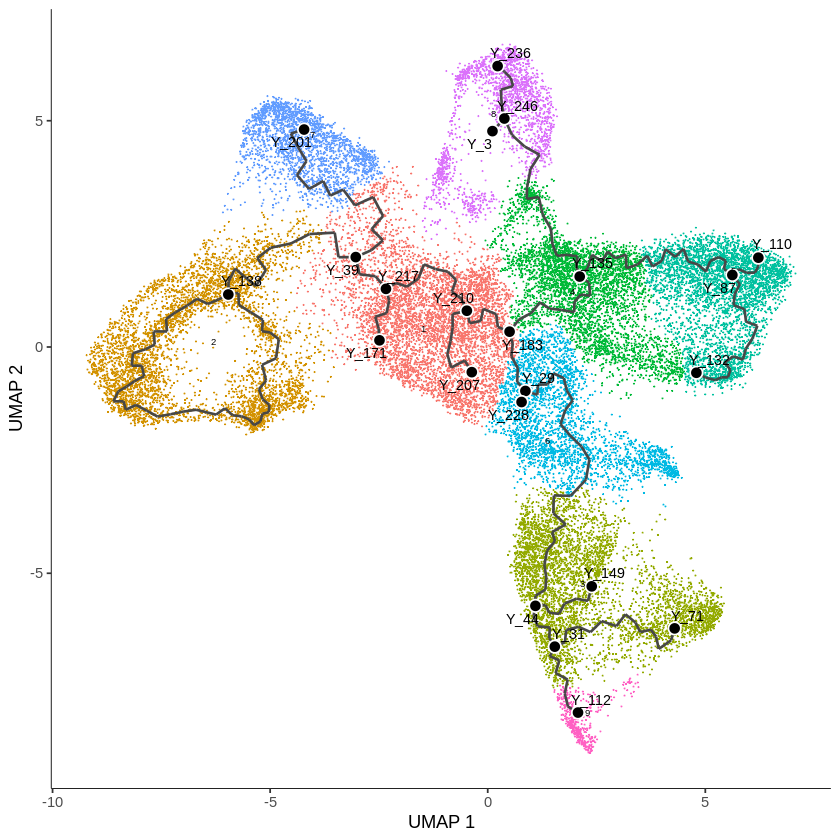

In [39]:
# plot trajectories colored by pseudotime
plot_cells(
  cds = se.cds,
  show_trajectory_graph = TRUE, label_principal_points = TRUE
)

In [ ]:
if (use.seurat){
   se.cds <- order_cells(se.cds, reduction_method = "UMAP", root_pr_nodes = c('Y_382',
                                                                              'Y_374',
                                                                              'Y_139',
                                                                              'Y_93'))
    branches = list("b1"=c(139, 143), "b2"=c(139, 308), "b3"=c(139, 167), 
                    "b4"=c(93, 167),"b5"= c(93, 498), "b6"=c(139, 82),
                    "b7"=c(374, 143), "b8"=c(374, 308),"b9"= c(374, 498), 
                    "b10"=c(374, 485), "b11"=c(374, 340), "b12"=c(374, 31), 
                    "b13"=c(374, 435),"b14"=c(374, 82))

}#else{
#    se.cds <- order_cells(se.cds, reduction_method = "UMAP", root_pr_nodes = c('Y_85',
#                                                                               'Y_88', 
#                                                                               'Y_117'))
#     branches = list("b1"=c(85, 18), "b2"=c(88, 18), "b3"=c(85, 60), "b4"=c(88, 60), 
#                  "b5"=c(85, 75), "b6"=c(85, 1), "b7"=c(85, 134), "b8"=c(85, 93))
#}
branches

In [ ]:
# plot trajectories colored by pseudotime
plot_cells(
  cds = se.cds,
  color_cells_by = "pseudotime",
  show_trajectory_graph = TRUE
)
ggsave(file.path(outdir, "SE.pseudotime.trajectory.png"))
ggsave(file.path(outdir, "SE.pseudotime.trajectory.pdf"))



In [ ]:
se <- AddMetaData(
  object = se,
  metadata = se.cds@principal_graph_aux@listData$UMAP$pseudotime,
  col.name = "pseudotime"
)


In [ ]:
FeaturePlot(se, c("pseudotime"), pt.size = 0.1) & scale_color_viridis_c()
ggsave(file.path(outdir, "SE.pseudotime.png"))
ggsave(file.path(outdir, "SE.pseudotime.pdf"))
FeaturePlot(se, c("nCount_ATAC"), pt.size = 0.1) & scale_color_viridis_c()
ggsave(file.path(outdir, "SE.pseudotime.nCountPeaks.png"))
ggsave(file.path(outdir, "SE.pseudotime.nCountPeaks.pdf"))




In [ ]:
#colData(se.cds)$cluster_labels <- se[["seurat_clusters"]]
#colData(se.cds)$cluster_labels

In [ ]:

#cds_subset = cluster_cells(cds_subset, resolution=1e-2)
#plot_cells(se.cds, color_cells_by="seurat_clusters")
#ggsave(file.path(outdir, "pseudo.clusters.png"))
#cds_subset = cluster_cells(cds_subset, resolution=1e-2)
# plot_cells(se.cds, color_cells_by="name")
# ggsave(file.path(outdir, "pseudo.clone.png"))
# ggsave(file.path(outdir, "pseudo.clone.pdf"))


# #cds_subset = cluster_cells(cds_subset, resolution=1e-2)
# plot_cells(se.cds, color_cells_by="donor")
# ggsave(file.path(outdir, "pseudo.donor.png"))
# ggsave(file.path(outdir, "pseudo.donor.pdf"))

In [ ]:
#plot_cells(se.cds, color_cells_by="seurat_clusters", label_cell_groups=TRUE)
plot_cells(se.cds, color_cells_by="cluster_labels", label_cell_groups=TRUE)

---

---

## Separate by segments

In [ ]:
plot_cells(se.cds, label_principal_points = TRUE)

## branches
label_principal_points = TRUE

(same area)
b1: 85, 18
b2: 119, 18
b3: 85, 60
b4, 119, 60

--
b5: 85,75
b6: 85, 1
b7: 85, 134
b8: 85,93

In [ ]:
colData(se.cds)["pseudotime"] = pseudotime(se.cds)

In [ ]:
choose_segments <- function(start_end, curr.se){
    print(start_end)
    return(choose_graph_segments(curr.se,
                          reduction_method = "UMAP",
                          starting_pr_node = start_end[1],
                          ending_pr_nodes = start_end[2]))
}

se.branches <- sapply(branches, choose_segments, curr.se=se.cds)

## Assign branch ID columns to each

In [ ]:
curr.se <- se.cds 
for (i in 1:length(se.branches)){
    curr.name <- names(se.branches)[i]
    colData(curr.se)[curr.name] = "FALSE"
    colData(curr.se)[colnames(se.branches[[i]]), curr.name ] = "TRUE"
    #print(names(se.branches)[i])   
}
curr.se
#sapply(se.branches, add.branch.id = ...,simplify = FALSE, USE.NAMES = TRUE)

In [ ]:
for (i in names(branches)){
    print(i)
    print(plot_cells(curr.se, color_cells_by=i) + ggtitle(i)) 
}

## save output

In [ ]:
write.table(colData(curr.se), file.path(outdir, "cells_meta_branchID.tsv"), sep="\t")

In [ ]:
#saveRDS(se, file.path(outdir, "SE.pseudotime.rds"))
saveRDS(curr.se, file.path(outdir, "SE.cds.rds"))

## Run DE

In [ ]:
## Pseudotime DE
#https://broadinstitute.github.io/2019_scWorkshop/functional-pseudotime-analysis.html

if(to_de){
    de_res <- graph_test(se.cds, neighbor_graph = "principal_graph", cores = 16)
    write.table(de_res, file.path(outdir, "branch.de.atac.tsv"),quote = FALSE, sep="\t")
    de_res
}



In [ ]:
## Run de within the subsets

# cds_subset <- se.branches[[1]]


# subset_pr_test_res <- graph_test(cds_subset, neighbor_graph="principal_graph", cores=4)
# pr_deg_ids <- row.names(subset(subset_pr_test_res, q_value < 0.05))
# gene_module_df <- find_gene_modules(cds_subset[pr_deg_ids,], resolution=0.001)
# agg_mat <- aggregate_gene_expression(cds_subset, gene_module_df)
# module_dendro <- hclust(dist(agg_mat))
# gene_module_df$module <- factor(gene_module_df$module, 
#                                 levels = row.names(agg_mat)[module_dendro$order])

# plot_cells(cds_subset,
#            genes=gene_module_df,
#            label_cell_groups=FALSE,
#            show_trajectory_graph=FALSE)

# cds_m <- reduce_dimension(cds = se.branches[[1]], reduction_method = "UMAP")
# cds_m <- cluster_cells(cds = se.branches[[1]], reduction_method = "UMAP")
# plot_cells(se.branches[[1]], color_cells_by="cluster_labels")

In [ ]:
# ## Interactive mode
# cds_m <- choose_graph_segments(
#   se.cds,
#   reduction_method = "UMAP",
# )
# cds_m
